In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

import xgboost as xgb
from xgboost import XGBRegressor

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\visha\.cache\kagglehub\datasets\robikscube\hourly-energy-consumption\versions\3


In [16]:
df = pd.read_csv(path + "/PJME_hourly.csv")

In [17]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.index
df = df.sort_index()

In [19]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


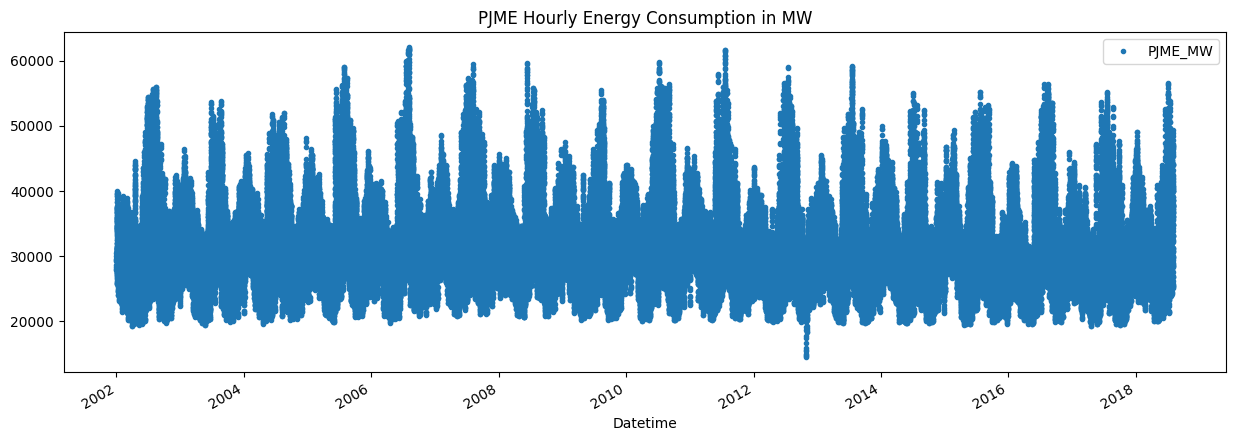

In [20]:
df.plot(figsize=(15, 5),
        style='.',
        title='PJME Hourly Energy Consumption in MW',
        color=color_pal[0])
plt.show()

<Axes: ylabel='Frequency'>

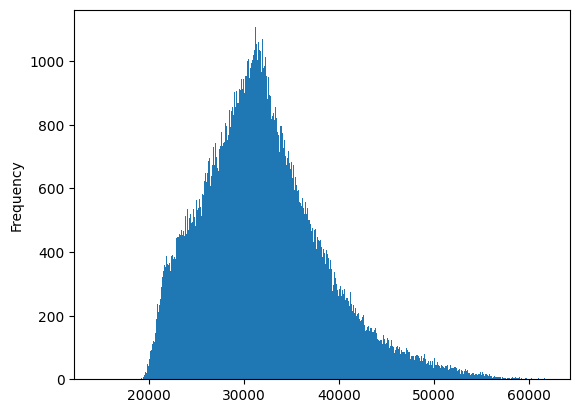

In [22]:
df['PJME_MW'].plot(kind='hist',bins=500)

<Axes: xlabel='Datetime'>

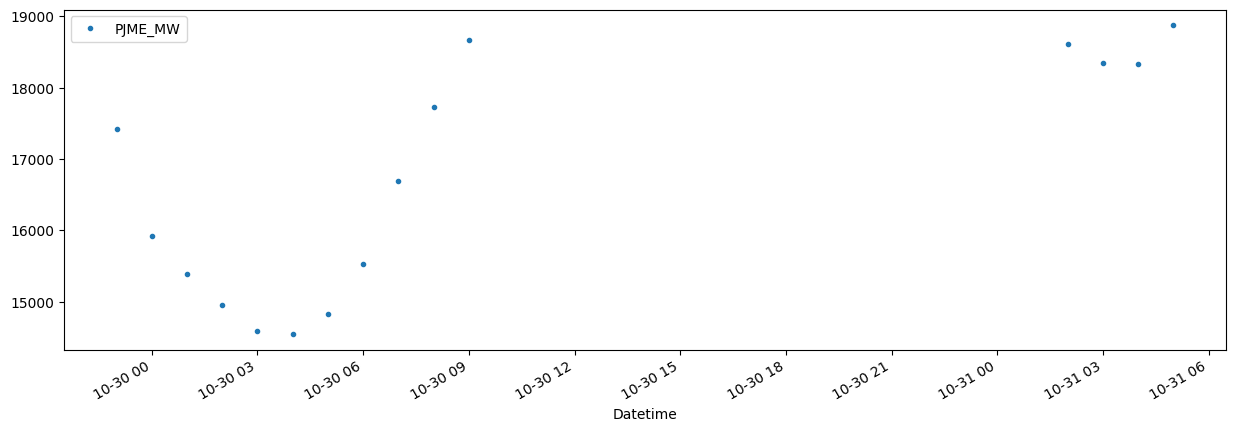

In [28]:
df.query("PJME_MW < 19000").plot(figsize=(15, 5),style='.')

In [29]:
df = df.query("PJME_MW > 19000").copy()

# Time Series split

In [31]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

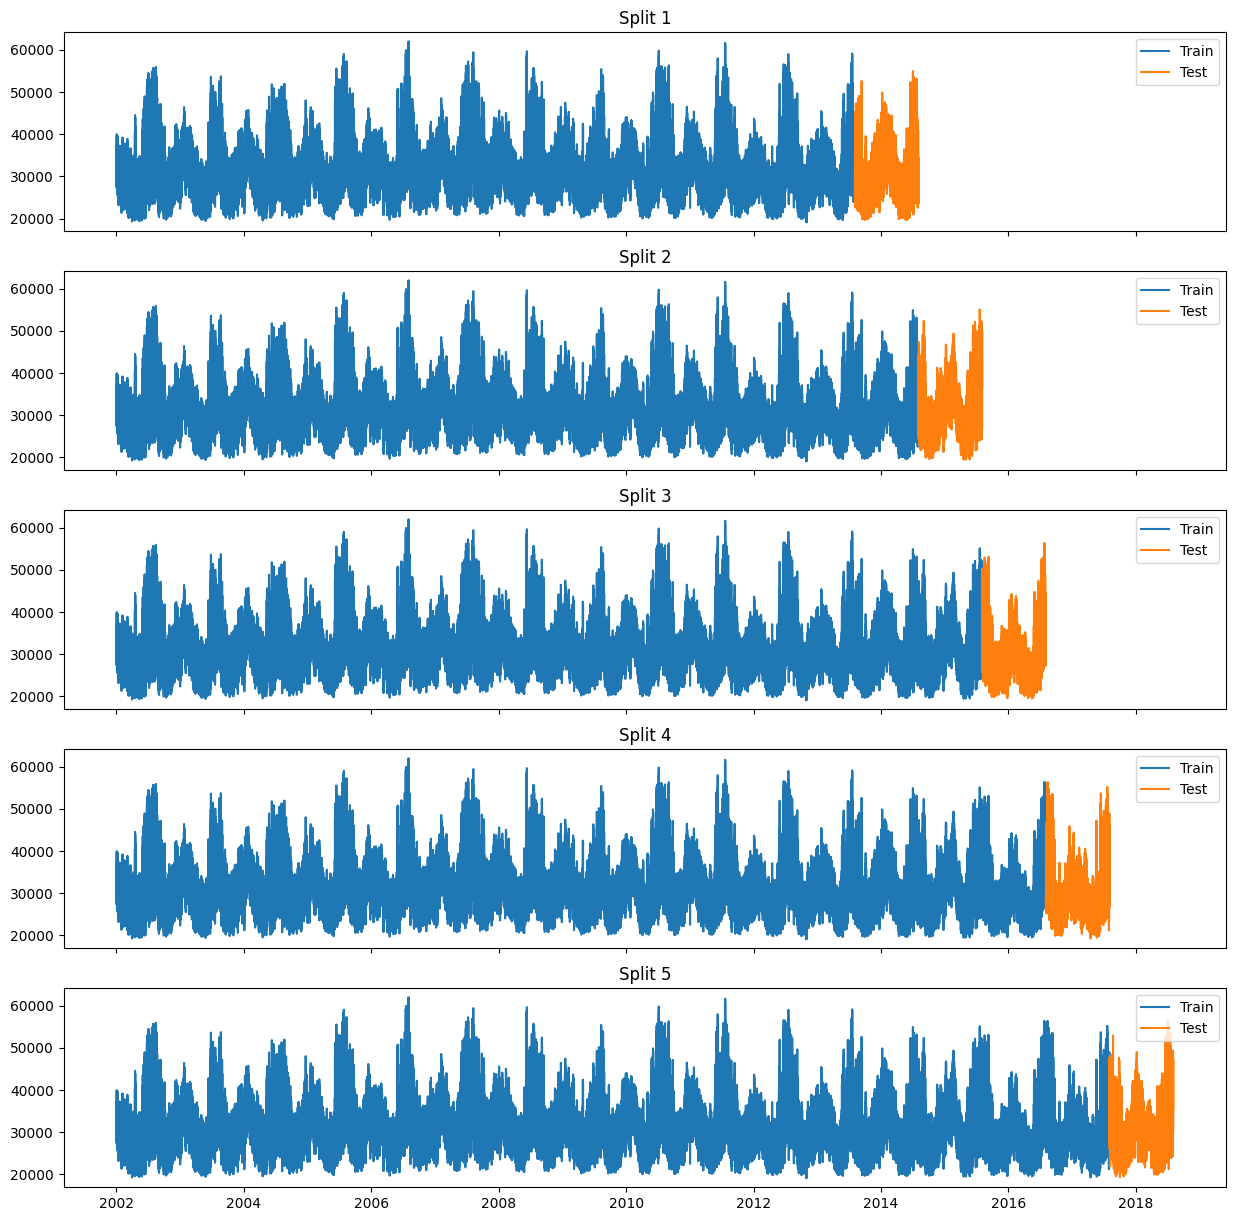

In [42]:
fig, axs = plt.subplots(5,1,figsize=(15, 15), sharex=True)

for i, (train_index, test_index) in enumerate(tss.split(df)):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    axs[i].plot(train.index, train['PJME_MW'], color=color_pal[0], label='Train')
    axs[i].plot(test.index, test['PJME_MW'], color=color_pal[1], label='Test')
    axs[i].set_title(f'Split {i+1}')
    axs[i].legend()

In [43]:
def create_date_features(df):
    """
    Create time series features based on time series index
    """    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_date_features(df)

## Lag Features

In [46]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [47]:
df = add_lags(df)

## Train Using Cross Validation

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_date_features(train)
    test = create_date_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = XGBRegressor(basescore=0.5, booster = 'gbtree' ,
                       n_estimators=1000, learning_rate=0.01, 
                       max_depth=3, early_stopping_rounds=50,
                       objective='reg:linear')
    
    reg.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[0]	validation_0-rmse:6457.15341	validation_1-rmse:6143.15464


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:02:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:02:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "basescore" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:4367.61761	validation_1-rmse:4107.31848
[200]	validation_0-rmse:3811.05165	validation_1-rmse:3767.45549
[300]	validation_0-rmse:3537.90755	validation_1-rmse:3718.59114
[338]	validation_0-rmse:3468.90114	validation_1-rmse:3725.26613
[0]	validation_0-rmse:6432.67201	validation_1-rmse:6250.31176


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "basescore" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:4370.38556	validation_1-rmse:4161.71011
[200]	validation_0-rmse:3834.60508	validation_1-rmse:3702.96107
[300]	validation_0-rmse:3577.46290	validation_1-rmse:3557.94999
[400]	validation_0-rmse:3431.04958	validation_1-rmse:3523.30431
[500]	validation_0-rmse:3347.65554	validation_1-rmse:3503.17686
[600]	validation_0-rmse:3296.98738	validation_1-rmse:3481.92088
[700]	validation_0-rmse:3258.00275	validation_1-rmse:3468.14492
[800]	validation_0-rmse:3221.57310	validation_1-rmse:3442.57635
[900]	validation_0-rmse:3192.92958	validation_1-rmse:3434.12419
[999]	validation_0-rmse:3168.33083	validation_1-rmse:3429.01816
[0]	validation_0-rmse:6418.05600	validation_1-rmse:6610.15587


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "basescore" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:4366.30542	validation_1-rmse:4474.46321
[200]	validation_0-rmse:3832.90079	validation_1-rmse:3918.90359
[300]	validation_0-rmse:3589.29381	validation_1-rmse:3705.92049
[400]	validation_0-rmse:3446.91365	validation_1-rmse:3627.02872
[500]	validation_0-rmse:3372.05666	validation_1-rmse:3609.53943
[543]	validation_0-rmse:3347.15229	validation_1-rmse:3611.42844
[0]	validation_0-rmse:6431.29690	validation_1-rmse:6652.31298


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "basescore" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:4366.52545	validation_1-rmse:4640.85964
[200]	validation_0-rmse:3828.69836	validation_1-rmse:4273.30315
[300]	validation_0-rmse:3588.51096	validation_1-rmse:4178.13505
[400]	validation_0-rmse:3450.19910	validation_1-rmse:4126.84474
[500]	validation_0-rmse:3375.75796	validation_1-rmse:4094.83591
[547]	validation_0-rmse:3348.27060	validation_1-rmse:4097.26263
[0]	validation_0-rmse:6445.37885	validation_1-rmse:6093.11176


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
c:\Anaconda\envs\py311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:03:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "basescore" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:4388.88398	validation_1-rmse:4185.62354
[200]	validation_0-rmse:3862.38505	validation_1-rmse:3875.87540
[292]	validation_0-rmse:3649.50719	validation_1-rmse:3874.04123


In [73]:
print(f'Score across folds {np.mean(scores):0.4f}')
print("Fold scores:", [round(float(s), 4) for s in scores])

Score across folds 3740.7695
Fold scores: [3718.0016, 3428.7642, 3606.9126, 4092.7943, 3857.3747]


In [64]:
np.mean(scores)

np.float64(3740.76946905018)

# Predicting Future

In [74]:
df = create_date_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


c:\Anaconda\envs\py311\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [75]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [76]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_date_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [77]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the Future

In [78]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

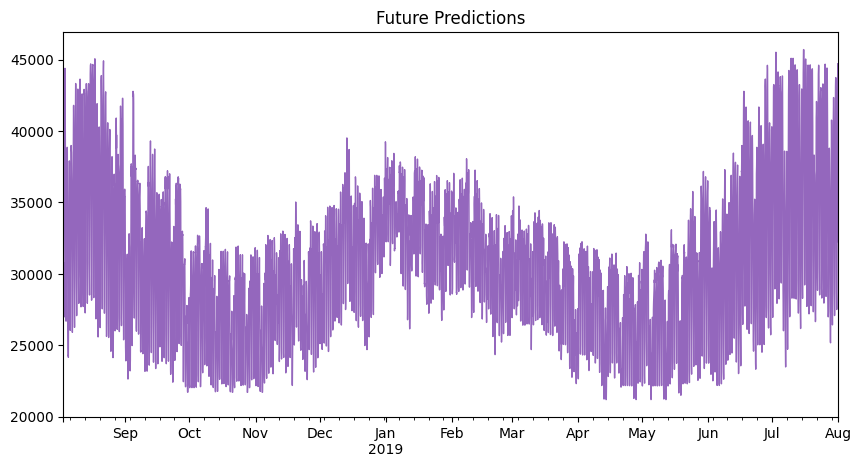

In [79]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()